# 🧩 OFDM Image Transmission

--> **Author:** Rahul Gulia  
--> **Ph.D. Student**  
--> **Rochester Institute of Technology**


# OFDM Model: Transmitting an image file


                                Input Data → Modulation (QAM/PSK) → Serial to Parallel → IFFT → Add Cyclic Prefix
                                                                       ↓

                                                Channel (with multipath fading and noise)
                                                                       ↓

                                Output Data ← Demodulation ← Parallel to Serial ← FFT ← Remove Cyclic Prefix

# Next Steps:

1. Advanced Channel Models
- Time-Varying Multipath Channels:
    - Simulate Doppler effects (e.g., Jakes model) for mobile scenarios (vehicular/drone communications).

- Phase Noise & CFO (Carrier Frequency Offset):
    - Add oscillator imperfections and compensate with pilot-aided phase tracking.

- Non-Linear Distortion:
    - Model power amplifier saturation (e.g., Rapp model) and include clipping noise mitigation.

2. Synchronization Enhancements
- Schmidl-Cox Algorithm:
    - Add a preamble for symbol timing and fractional CFO estimation.

- Integer CFO Estimation:
    - Use frequency-domain correlation with a repeated preamble.

3. Peak-to-Average Power Ratio (PAPR) Reduction

- Clipping & Filtering:
    - Artificially clip high peaks and filter out-of-band noise.

- Tone Reservation:
    - Reserve 5% of subcarriers for PAPR reduction (e.g., gradient descent to optimize reserved tones).

4. Adaptive Modulation & Coding (AMC)

- SNR-Based Modulation Switching:
    - Dynamically select QPSK/16-QAM/64-QAM per subcarrier based on instantaneous SNR.

- Hybrid ARQ:
    - Simulate retransmissions for failed blocks (e.g., CRC check).

5. Frequency Synchronization Improvements

- Sample Rate Offset (SRO) Compensation:
    - Model clock drift between Tx/Rx and correct via pilot phase tracking.

- Inter-Carrier Interference (ICI) Cancellation:
    - Use windowed OFDM (e.g., raised cosine window) to reduce spectral leakage.

6. Hardware-Oriented Optimizations

- Quantization Effects:
    - Simulate ADC/DAC bit resolution (e.g., 8-bit vs. 12-bit) impact on BER.

- Low-Complexity Equalizers:
    - Implement MMSE equalization with toeplitz matrix approximation for reduced complexity.

7. Nonlinear Equalization

- Decision Feedback Equalizer (DFE):
    - Combine FFT-based equalization with time-domain feedback for severe ISI.

- Volterra Series:
    - Model and compensate for nonlinear channel distortions.



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import interpolate

# === Helper Functions (helper_function.py - Integrated) ===
def get_modulation_config(mod_scheme):
    if mod_scheme == 'BPSK':
        return {'bits_per_symbol': 1, 'constellation': np.array([-1+0j, 1+0j])}
    elif mod_scheme == 'QPSK':
        return {'bits_per_symbol': 2, 'constellation': np.array([-1-1j, -1+1j, 1-1j, 1+1j]) / np.sqrt(2)}
    elif mod_scheme == '8-PSK':
        return {'bits_per_symbol': 3, 'constellation': np.exp(1j * np.arange(0, 2 * np.pi, 2 * np.pi / 8))}
    elif mod_scheme == '16-QAM':
        return {'bits_per_symbol': 4, 'constellation': np.array([-3-3j, -3-1j, -3+3j, -3+1j,
                                                                 -1-3j, -1-1j, -1+3j, -1+1j,
                                                                  3-3j,  3-1j,  3+3j,  3+1j,
                                                                  1-3j,  1-1j,  1+3j,  1+1j]) / np.sqrt(10)}
    elif mod_scheme == '64-QAM':
        levels = [-7, -5, -3, -1, 1, 3, 5, 7]
        constellation = np.array([x + 1j * y for y in levels for x in levels]) / np.sqrt(42)
        return {'bits_per_symbol': 6, 'constellation': constellation}
    elif mod_scheme == '256-QAM':
        levels = [-15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15]
        constellation = np.array([x + 1j * y for y in levels for x in levels]) / np.sqrt(170)
        return {'bits_per_symbol': 8, 'constellation': constellation}
    else:
        raise ValueError(f"Unsupported modulation scheme: {mod_scheme}")

def modulate_bits(bits, mod_scheme):
    config = get_modulation_config(mod_scheme)
    bits_per_symbol = config['bits_per_symbol']
    constellation = config['constellation']
    num_symbols = len(bits) // bits_per_symbol
    if len(bits) % bits_per_symbol != 0:
        raise ValueError("Number of bits must be a multiple of bits per symbol.")
    indices = bits.reshape(-1, bits_per_symbol).dot(1 << np.arange(bits_per_symbol - 1, -1, -1))
    return constellation[indices]

def demodulate_symbols(symbols, mod_scheme):
    config = get_modulation_config(mod_scheme)
    constellation = config['constellation']
    bits_per_symbol = config['bits_per_symbol']
    demodulated_bits = []
    for symbol in symbols:
        distances = np.abs(constellation - symbol)**2
        closest_index = np.argmin(distances)
        binary_representation = np.binary_repr(closest_index, width=bits_per_symbol)
        demodulated_bits.extend([int(b) for b in binary_representation])
    return np.array(demodulated_bits)

def add_awgn(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    if np.iscomplexobj(signal):
        noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    else:
        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

def plot_constellation(received_symbols, transmitted_symbols=None):
    plt.scatter(np.real(received_symbols), np.imag(received_symbols), marker='o', label='Received Symbols')
    if transmitted_symbols is not None:
        plt.scatter(np.real(transmitted_symbols), np.imag(transmitted_symbols), marker='x', color='red', label='Transmitted Symbols')
    plt.xlabel('In-Phase')
    plt.ylabel('Quadrature')
    plt.title('Constellation Diagram')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')




--- Calculating BER vs SNR for Modulation: BPSK ---
SNR: 0 dB, BER: 1.90e-01 (BPSK)
SNR: 2 dB, BER: 1.34e-01 (BPSK)
SNR: 4 dB, BER: 9.65e-02 (BPSK)
SNR: 6 dB, BER: 7.77e-02 (BPSK)
SNR: 8 dB, BER: 7.24e-02 (BPSK)
SNR: 10 dB, BER: 7.14e-02 (BPSK)
SNR: 12 dB, BER: 7.14e-02 (BPSK)
SNR: 14 dB, BER: 7.14e-02 (BPSK)
SNR: 16 dB, BER: 7.14e-02 (BPSK)
SNR: 18 dB, BER: 7.14e-02 (BPSK)
SNR: 20 dB, BER: 7.14e-02 (BPSK)
SNR: 22 dB, BER: 7.14e-02 (BPSK)
SNR: 24 dB, BER: 7.14e-02 (BPSK)
SNR: 26 dB, BER: 7.14e-02 (BPSK)
SNR: 28 dB, BER: 7.14e-02 (BPSK)
SNR: 30 dB, BER: 7.14e-02 (BPSK)
SNR: 32 dB, BER: 7.14e-02 (BPSK)
SNR: 34 dB, BER: 7.14e-02 (BPSK)
SNR: 36 dB, BER: 7.14e-02 (BPSK)
SNR: 38 dB, BER: 7.14e-02 (BPSK)

--- Calculating BER vs SNR for Modulation: QPSK ---
SNR: 0 dB, BER: 2.78e-01 (QPSK)
SNR: 2 dB, BER: 2.21e-01 (QPSK)
SNR: 4 dB, BER: 1.68e-01 (QPSK)
SNR: 6 dB, BER: 1.24e-01 (QPSK)
SNR: 8 dB, BER: 9.70e-02 (QPSK)
SNR: 10 dB, BER: 8.40e-02 (QPSK)
SNR: 12 dB, BER: 8.04e-02 (QPSK)
SNR: 14 dB, B

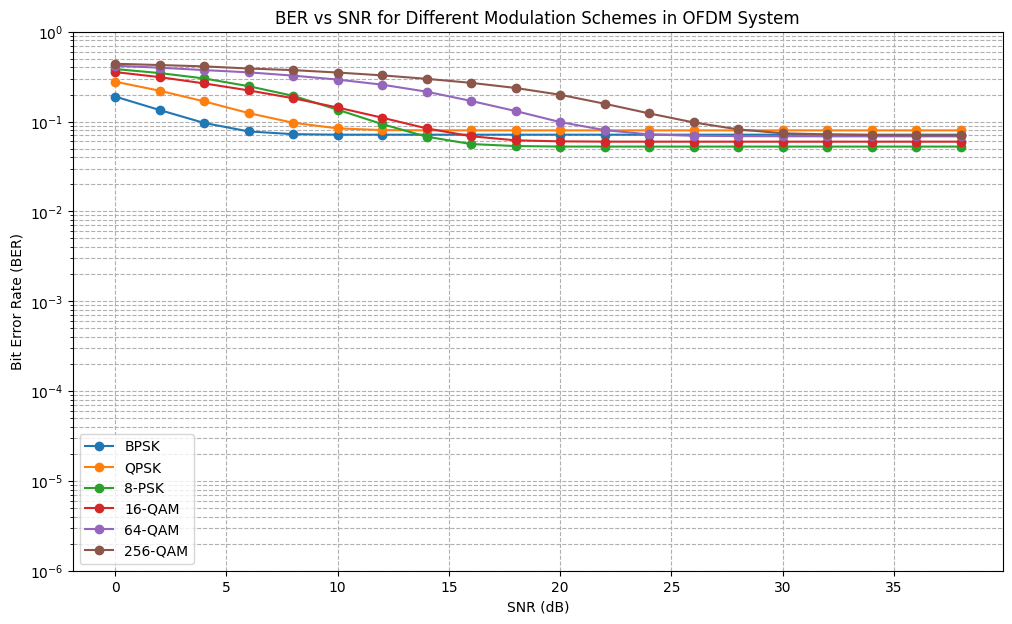


--- Reconstructing Image with Modulation: BPSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: QPSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 8-PSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 16-QAM at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 64-QAM at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 256-QAM at SNR = 30 dB ---


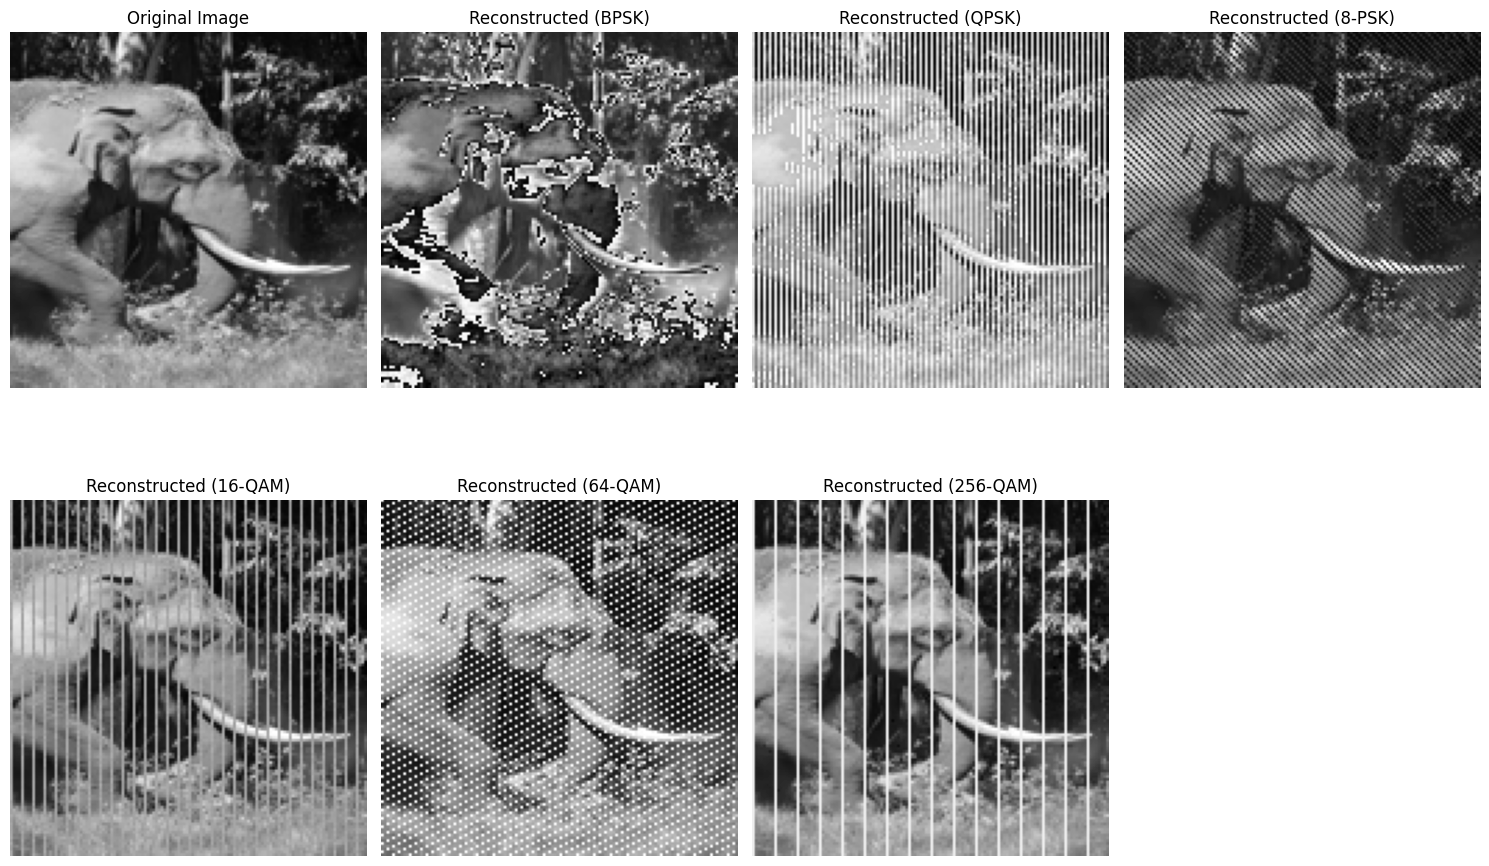

In [ ]:

# === Main Script ===
if __name__ == "__main__":
    # === Step 1: Load and Preprocess Image ===
    img_path = "/home/rg9828/Documents/Blogger/Physical_Layer/PHYSICAL_Layer/OFDM/pexels-tian-2499271.jpg"
    try:
        img = Image.open(img_path).convert('L')  # Grayscale
        img = img.resize((128, 128))             # Resize image
        img_array = np.array(img)
        binary_data = np.unpackbits(img_array.astype(np.uint8))  # Flatten to 1D binary
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}. Using random binary data instead.")
        binary_data = np.random.randint(0, 2, 128 * 128 * 8)

    # === Step 2: OFDM Configuration ===
    N = 64  # OFDM subcarriers
    CP = 16
    modulation_schemes = ['BPSK', 'QPSK', '8-PSK', '16-QAM', '64-QAM', '256-QAM']
    snr_db_values = np.arange(0, 40, 2)  # Increased SNR range to accommodate higher modulations
    pilot_positions = np.arange(0, N, 8)  # Increased pilot density
    channel_taps = np.array([0.9, 0.2 * np.exp(-1j * np.pi / 4)]) # More realistic channel

    ber_results_all_schemes = {}

    # === Step 3: BER Calculation for Each Modulation Scheme ===
    for mod_scheme in modulation_schemes:
        print(f"\n--- Calculating BER vs SNR for Modulation: {mod_scheme} ---")
        ber_results = []
        mod_config = get_modulation_config(mod_scheme)
        bits_per_symbol = mod_config['bits_per_symbol']
        num_symbols = len(binary_data) // bits_per_symbol
        tx_bits_original = np.array(binary_data[:num_symbols * bits_per_symbol])
        tx_symbols_original = modulate_bits(tx_bits_original, mod_scheme)

        for snr_db in snr_db_values:
            symbols = np.copy(tx_symbols_original)
            if len(symbols) % N != 0:
                padding_len = N - len(symbols) % N
                symbols = np.concatenate([symbols, np.zeros(padding_len, dtype=complex)])

            num_ofdm_blocks = len(symbols) // N
            ofdm_blocks = symbols.reshape(num_ofdm_blocks, N)
            pilot_value = 1 + 1j
            for block in ofdm_blocks:
                block[pilot_positions] = pilot_value

            time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
            time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
            tx_signal = time_blocks_cp.flatten()

            # Channel and Noise
            rx_signal = add_awgn(tx_signal, snr_db)
            rx_signal = np.convolve(rx_signal, channel_taps, mode='same')

            # OFDM Demodulation
            num_rx_blocks = len(rx_signal) // (N + CP)
            if num_rx_blocks * (N + CP) > len(rx_signal):
                num_rx_blocks -= 1
            rx_blocks = rx_signal[:num_rx_blocks * (N + CP)].reshape(-1, N + CP)
            rx_blocks_cp_removed = rx_blocks[:, CP:]
            rx_symbols_blocks_noisy = np.fft.fft(rx_blocks_cp_removed, axis=1)

            # Channel Estimation
            H_est = np.zeros_like(rx_symbols_blocks_noisy, dtype=complex)
            pilot_indices = np.array(pilot_positions)
            for block_idx in range(rx_symbols_blocks_noisy.shape[0]):
                received_pilots = rx_symbols_blocks_noisy[block_idx, pilot_indices]
                channel_at_pilots = received_pilots / pilot_value
                interp_real = interpolate.interp1d(pilot_indices, np.real(channel_at_pilots), kind='linear', fill_value="extrapolate")
                interp_imag = interpolate.interp1d(pilot_indices, np.imag(channel_at_pilots), kind='linear', fill_value="extrapolate")
                H_est[block_idx, :] = interp_real(np.arange(N)) + 1j * interp_imag(np.arange(N))

            # Equalization
            rx_symbols_eq_blocks = rx_symbols_blocks_noisy / H_est
            rx_symbols_eq = rx_symbols_eq_blocks.flatten()[:len(tx_symbols_original)]

            # Demodulation
            rx_bits_final = demodulate_symbols(rx_symbols_eq, mod_scheme)[:len(tx_bits_original)]

            # BER Calculation
            ber = np.mean(rx_bits_final != tx_bits_original)
            ber_results.append(ber)
            print(f"SNR: {snr_db} dB, BER: {ber:.2e} ({mod_scheme})")

        ber_results_all_schemes[mod_scheme] = ber_results

    # === Step 4: Plot BER Curves ===
    plt.figure(figsize=(12, 7))
    for mod_scheme, ber_results in ber_results_all_schemes.items():
        plt.semilogy(snr_db_values, ber_results, marker='o', linestyle='-', label=mod_scheme)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.title('BER vs SNR for Different Modulation Schemes in OFDM System')
    plt.grid(True, which="both", ls="--")
    plt.ylim(1e-6, 1)
    plt.legend()
    plt.show()

    # === Step 5: Reconstruct Image for a Fixed SNR ===
    fixed_snr_db = 30  # Increased SNR for higher modulations
    num_rows = 2
    num_cols = 4
    plt.figure(figsize=(15, 10))
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    for i, mod_scheme in enumerate(modulation_schemes):
        print(f"\n--- Reconstructing Image with Modulation: {mod_scheme} at SNR = {fixed_snr_db} dB ---")
        mod_config = get_modulation_config(mod_scheme)
        bits_per_symbol = mod_config['bits_per_symbol']
        num_symbols = len(binary_data) // bits_per_symbol
        tx_bits_original = np.array(binary_data[:num_symbols * bits_per_symbol])
        tx_symbols_original = modulate_bits(tx_bits_original, mod_scheme)

        symbols = np.copy(tx_symbols_original)
        if len(symbols) % N != 0:
            padding_len = N - len(symbols) % N
            symbols = np.concatenate([symbols, np.zeros(padding_len, dtype=complex)])

        num_ofdm_blocks = len(symbols) // N
        ofdm_blocks = symbols.reshape(num_ofdm_blocks, N)
        pilot_value = 1 + 1j
        for block in ofdm_blocks:
            block[pilot_positions] = pilot_value

        time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
        time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
        tx_signal = time_blocks_cp.flatten()

        # Channel and Noise
        rx_signal = add_awgn(tx_signal, fixed_snr_db)
        rx_signal = np.convolve(rx_signal, channel_taps, mode='same')

        # OFDM Demodulation
        num_rx_blocks = len(rx_signal) // (N + CP)
        if num_rx_blocks * (N + CP) > len(rx_signal):
            num_rx_blocks -= 1
        rx_blocks = rx_signal[:num_rx_blocks * (N + CP)].reshape(-1, N + CP)
        rx_blocks_cp_removed = rx_blocks[:, CP:]
        rx_symbols_blocks_noisy = np.fft.fft(rx_blocks_cp_removed, axis=1)

        # Channel Estimation
        H_est = np.zeros_like(rx_symbols_blocks_noisy, dtype=complex)
        pilot_indices = np.array(pilot_positions)
        for block_idx in range(rx_symbols_blocks_noisy.shape[0]):
            received_pilots = rx_symbols_blocks_noisy[block_idx, pilot_indices]
            channel_at_pilots = received_pilots / pilot_value
            interp_real = interpolate.interp1d(pilot_indices, np.real(channel_at_pilots), kind='linear', fill_value="extrapolate")
            interp_imag = interpolate.interp1d(pilot_indices, np.imag(channel_at_pilots), kind='linear', fill_value="extrapolate")
            H_est[block_idx, :] = interp_real(np.arange(N)) + 1j * interp_imag(np.arange(N))

        # Equalization
        rx_symbols_eq_blocks = rx_symbols_blocks_noisy / H_est
        rx_symbols_eq = rx_symbols_eq_blocks.flatten()[:len(tx_symbols_original)]

        # Demodulation
        rx_bits_final = demodulate_symbols(rx_symbols_eq, mod_scheme)[:len(tx_bits_original)]
        rx_bits_padded = np.pad(rx_bits_final, (0, binary_data.size - len(rx_bits_final)), 'constant')
        rx_bits_packed = np.packbits(rx_bits_padded)
        rx_image_array = rx_bits_packed[:128*128].reshape((128, 128))
        rx_image = Image.fromarray(rx_image_array.astype(np.uint8))

        # Plot Reconstructed Image
        plt.subplot(num_rows, num_cols, i + 2)
        plt.imshow(rx_image, cmap='gray')
        plt.title(f"Reconstructed ({mod_scheme})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    

In [11]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import interpolate
from scipy.signal import filtfilt

def get_modulation_config(mod_scheme):
    if mod_scheme == 'BPSK':
        return {'bits_per_symbol': 1, 'constellation': np.array([-1+0j, 1+0j])}
    elif mod_scheme == 'QPSK':
        return {'bits_per_symbol': 2, 'constellation': np.array([-1-1j, -1+1j, 1-1j, 1+1j]) / np.sqrt(2)}
    elif mod_scheme == '8-PSK':
        return {'bits_per_symbol': 3, 'constellation': np.exp(1j * np.arange(0, 2 * np.pi, 2 * np.pi / 8))}
    elif mod_scheme == '16-QAM':
        return {'bits_per_symbol': 4, 'constellation': np.array([-3-3j, -3-1j, -3+3j, -3+1j,
                                                                 -1-3j, -1-1j, -1+3j, -1+1j,
                                                                  3-3j,  3-1j,  3+3j,  3+1j,
                                                                  1-3j,  1-1j,  1+3j,  1+1j]) / np.sqrt(10)}
    elif mod_scheme == '64-QAM':
        levels = [-7, -5, -3, -1, 1, 3, 5, 7]
        constellation = np.array([x + 1j * y for y in levels for x in levels]) / np.sqrt(42)
        return {'bits_per_symbol': 6, 'constellation': constellation}
    elif mod_scheme == '256-QAM':
        levels = [-15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15]
        constellation = np.array([x + 1j * y for y in levels for x in levels]) / np.sqrt(170)
        return {'bits_per_symbol': 8, 'constellation': constellation}
    else:
        raise ValueError(f"Unsupported modulation scheme: {mod_scheme}")

def modulate_bits(bits, mod_scheme):
    config = get_modulation_config(mod_scheme)
    bits_per_symbol = config['bits_per_symbol']
    constellation = config['constellation']
    num_symbols = len(bits) // bits_per_symbol
    if len(bits) % bits_per_symbol != 0:
        raise ValueError("Number of bits must be a multiple of bits per symbol.")
    indices = bits.reshape(-1, bits_per_symbol).dot(1 << np.arange(bits_per_symbol - 1, -1, -1))
    return constellation[indices]

def demodulate_symbols(symbols, mod_scheme):
    config = get_modulation_config(mod_scheme)
    constellation = config['constellation']
    bits_per_symbol = config['bits_per_symbol']
    demodulated_bits = []
    for symbol in symbols:
        distances = np.abs(constellation - symbol)**2
        closest_index = np.argmin(distances)
        binary_representation = np.binary_repr(closest_index, width=bits_per_symbol)
        demodulated_bits.extend([int(b) for b in binary_representation])
    return np.array(demodulated_bits)

def add_awgn(signal, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / snr_linear
    if np.iscomplexobj(signal):
        noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    else:
        noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)
    return signal + noise

def plot_constellation(received_symbols, transmitted_symbols=None):
    plt.scatter(np.real(received_symbols), np.imag(received_symbols), marker='o', label='Received Symbols')
    if transmitted_symbols is not None:
        plt.scatter(np.real(transmitted_symbols), np.imag(transmitted_symbols), marker='x', color='red', label='Transmitted Symbols')
    plt.xlabel('In-Phase')
    plt.ylabel('Quadrature')
    plt.title('Constellation Diagram')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')

def jakes_doppler_filter(num_taps, f_d, fs):
    """Generate Jakes' Doppler filter coefficients."""
    t = np.arange(-num_taps//2, num_taps//2) / fs
    h = np.zeros_like(t, dtype=complex)
    valid_indices = np.where(np.abs(t) < 1/(2*f_d))  # Bandlimit to Doppler frequency
    h[valid_indices] = np.sqrt(1/(np.pi*f_d*np.sqrt(1 - (2*f_d*t[valid_indices])**2)))
    return h / np.sum(np.abs(h))  # Normalize filter

def time_varying_channel(signal, velocity, carrier_freq=2.4e9, sampling_rate=1e6):
    """Apply time-varying multipath channel with Doppler."""
    c = 3e8  # Speed of light
    f_d = velocity * carrier_freq / c  # Doppler frequency
    num_taps = min(32, len(signal)//2)  # Ensure filter is shorter than signal
    
    # Only apply Doppler if signal is long enough
    if len(signal) > 2*num_taps:
        h_doppler = jakes_doppler_filter(num_taps, f_d, sampling_rate)
        # Apply time-varying convolution
        channel_output = np.convolve(signal, h_doppler, mode='same')
    else:
        # Fallback: simple static channel for short signals
        channel_output = np.convolve(signal, channel_taps, mode='same')
    
    return channel_output

def add_phase_noise_cfo(signal, cfo_hz, phase_noise_var, fs):
    """Add phase noise and CFO to the signal."""
    n = np.arange(len(signal))
    cfo_phase = 2 * np.pi * cfo_hz * n / fs
    phase_noise = np.cumsum(np.sqrt(phase_noise_var) * np.random.randn(len(signal)))
    distorted_signal = signal * np.exp(1j * (cfo_phase + phase_noise))
    return distorted_signal

def cfo_phase_compensation(ofdm_symbols, pilot_symbols, pilot_positions, fs):
    """Pilot-aided CFO/phase tracking."""
    estimated_phase = np.angle(ofdm_symbols[pilot_positions] / pilot_symbols)
    interp_phase = np.interp(np.arange(len(ofdm_symbols)), pilot_positions, estimated_phase)
    compensated_symbols = ofdm_symbols * np.exp(-1j * interp_phase)
    return compensated_symbols

def rapp_amplifier(x, A_sat=1.0, p=3):
    """Apply Rapp model for PA non-linearity."""
    return x / (1 + (np.abs(x) / A_sat)**(2 * p)) ** (1 / (2 * p))


--- Calculating BER vs SNR for Modulation: BPSK ---
SNR: 0 dB, BER: 5.03e-01 (BPSK)
SNR: 2 dB, BER: 5.05e-01 (BPSK)
SNR: 4 dB, BER: 5.06e-01 (BPSK)
SNR: 6 dB, BER: 5.06e-01 (BPSK)
SNR: 8 dB, BER: 5.05e-01 (BPSK)
SNR: 10 dB, BER: 5.04e-01 (BPSK)
SNR: 12 dB, BER: 5.06e-01 (BPSK)
SNR: 14 dB, BER: 5.05e-01 (BPSK)
SNR: 16 dB, BER: 5.06e-01 (BPSK)
SNR: 18 dB, BER: 5.08e-01 (BPSK)
SNR: 20 dB, BER: 5.09e-01 (BPSK)
SNR: 22 dB, BER: 5.08e-01 (BPSK)
SNR: 24 dB, BER: 5.09e-01 (BPSK)
SNR: 26 dB, BER: 5.08e-01 (BPSK)
SNR: 28 dB, BER: 5.07e-01 (BPSK)
SNR: 30 dB, BER: 5.09e-01 (BPSK)
SNR: 32 dB, BER: 5.08e-01 (BPSK)
SNR: 34 dB, BER: 5.06e-01 (BPSK)
SNR: 36 dB, BER: 5.08e-01 (BPSK)
SNR: 38 dB, BER: 5.09e-01 (BPSK)

--- Calculating BER vs SNR for Modulation: QPSK ---
SNR: 0 dB, BER: 5.13e-01 (QPSK)
SNR: 2 dB, BER: 5.13e-01 (QPSK)
SNR: 4 dB, BER: 5.12e-01 (QPSK)
SNR: 6 dB, BER: 5.15e-01 (QPSK)
SNR: 8 dB, BER: 5.11e-01 (QPSK)
SNR: 10 dB, BER: 5.13e-01 (QPSK)
SNR: 12 dB, BER: 5.13e-01 (QPSK)
SNR: 14 dB, B

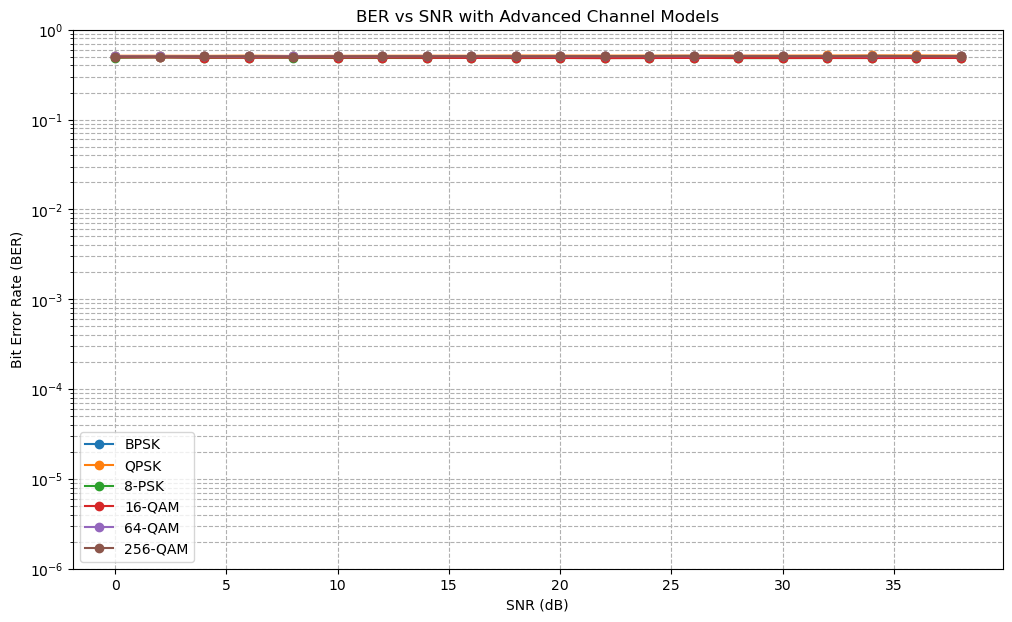


--- Reconstructing Image with Modulation: BPSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: QPSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 8-PSK at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 16-QAM at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 64-QAM at SNR = 30 dB ---

--- Reconstructing Image with Modulation: 256-QAM at SNR = 30 dB ---


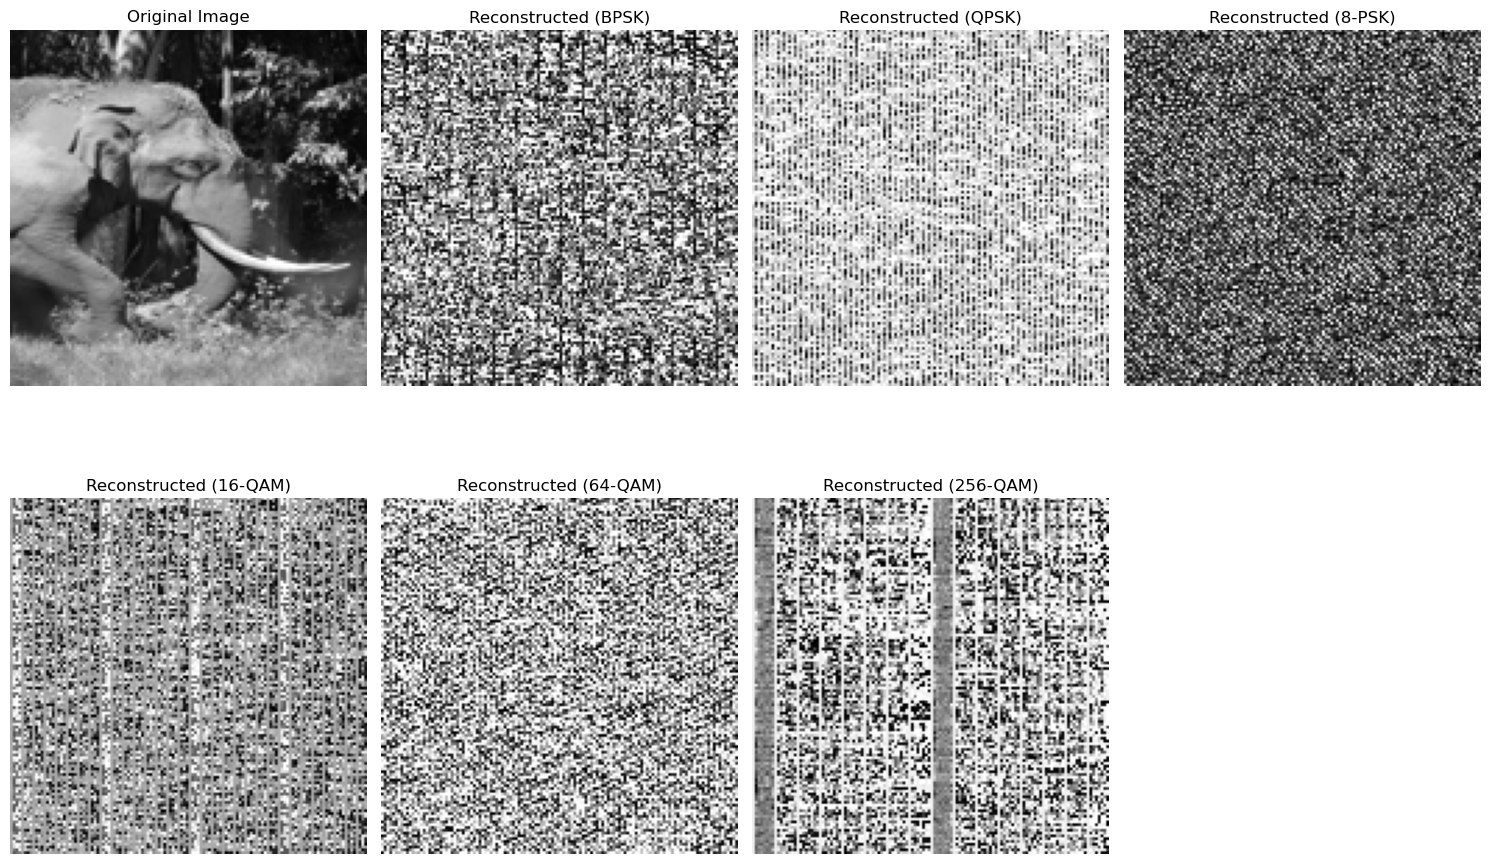

In [ ]:
# === Main Script ===
if __name__ == "__main__":
    # === New Configuration Parameters ===
    VELOCITY = 30  # m/s (for Doppler, ~108 km/h)
    CARRIER_FREQ = 2.4e9  # 2.4 GHz
    PHASE_NOISE_VAR = 0.01  # Phase noise variance
    CFO_HZ = 100  # Carrier frequency offset in Hz
    PA_SATURATION = 0.8  # Rapp model saturation level
    PA_SMOOTHING = 3  # Rapp model smoothing factor

    # === Step 1: Load and Preprocess Image ===
    img_path = "/home/rg9828/Documents/Blogger/Physical_Layer/PHYSICAL_Layer/OFDM/pexels-tian-2499271.jpg"
    try:
        img = Image.open(img_path).convert('L')  # Grayscale
        img = img.resize((128, 128))             # Resize image
        img_array = np.array(img)
        binary_data = np.unpackbits(img_array.astype(np.uint8))  # Flatten to 1D binary
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}. Using random binary data instead.")
        binary_data = np.random.randint(0, 2, 128 * 128 * 8)

    # === Step 2: OFDM Configuration ===
    N = 64  # OFDM subcarriers
    CP = 16
    modulation_schemes = ['BPSK', 'QPSK', '8-PSK', '16-QAM', '64-QAM', '256-QAM']
    snr_db_values = np.arange(0, 40, 2)
    pilot_positions = np.arange(0, N, 8)
    channel_taps = np.array([0.9, 0.2 * np.exp(-1j * np.pi / 4)])

    ber_results_all_schemes = {}

    # === Step 3: BER Calculation for Each Modulation Scheme ===
    for mod_scheme in modulation_schemes:
        print(f"\n--- Calculating BER vs SNR for Modulation: {mod_scheme} ---")
        ber_results = []
        mod_config = get_modulation_config(mod_scheme)
        bits_per_symbol = mod_config['bits_per_symbol']
        num_symbols = len(binary_data) // bits_per_symbol
        tx_bits_original = np.array(binary_data[:num_symbols * bits_per_symbol])
        tx_symbols_original = modulate_bits(tx_bits_original, mod_scheme)

        for snr_db in snr_db_values:
            symbols = np.copy(tx_symbols_original)
            if len(symbols) % N != 0:
                padding_len = N - len(symbols) % N
                symbols = np.concatenate([symbols, np.zeros(padding_len, dtype=complex)])

            num_ofdm_blocks = len(symbols) // N
            ofdm_blocks = symbols.reshape(num_ofdm_blocks, N)
            pilot_value = 1 + 1j
            for block in ofdm_blocks:
                block[pilot_positions] = pilot_value

            time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
            time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
            tx_signal = time_blocks_cp.flatten()

            # === Advanced Channel Effects ===
            # 1. Power Amplifier Non-Linearity (Rapp Model)
            # Channel and Noise
            tx_signal = rapp_amplifier(tx_signal, A_sat=PA_SATURATION, p=PA_SMOOTHING)
            
            # Process in chunks if signal is too long
            chunk_size = 1024  # Process in chunks of 1024 samples
            tx_signal_channel = np.zeros_like(tx_signal, dtype=complex)
            for i in range(0, len(tx_signal), chunk_size):
                chunk = tx_signal[i:i+chunk_size]
                tx_signal_channel[i:i+chunk_size] = time_varying_channel(
                    chunk, velocity=VELOCITY,
                    carrier_freq=CARRIER_FREQ,
                    sampling_rate=1e6
                )
            
            tx_signal = add_phase_noise_cfo(tx_signal_channel, cfo_hz=CFO_HZ,
                                        phase_noise_var=PHASE_NOISE_VAR, fs=1e6)
            rx_signal = add_awgn(tx_signal, snr_db)

            # OFDM Demodulation
            num_rx_blocks = len(rx_signal) // (N + CP)
            if num_rx_blocks * (N + CP) > len(rx_signal):
                num_rx_blocks -= 1
            rx_blocks = rx_signal[:num_rx_blocks * (N + CP)].reshape(-1, N + CP)
            rx_blocks_cp_removed = rx_blocks[:, CP:]
            rx_symbols_blocks_noisy = np.fft.fft(rx_blocks_cp_removed, axis=1)

            # === Advanced Receiver Processing ===
            # 1. CFO and Phase Noise Compensation (Pilot-Aided)
            for block_idx in range(rx_symbols_blocks_noisy.shape[0]):
                rx_symbols_blocks_noisy[block_idx] = cfo_phase_compensation(
                    rx_symbols_blocks_noisy[block_idx], pilot_value, 
                    pilot_positions, fs=1e6
                )

            # Channel Estimation (Modified for Time-Varying Channels)
            H_est = np.zeros_like(rx_symbols_blocks_noisy, dtype=complex)
            pilot_indices = np.array(pilot_positions)
            for block_idx in range(rx_symbols_blocks_noisy.shape[0]):
                received_pilots = rx_symbols_blocks_noisy[block_idx, pilot_indices]
                channel_at_pilots = received_pilots / pilot_value
                interp_real = interpolate.interp1d(pilot_indices, np.real(channel_at_pilots), 
                                      kind='linear', fill_value="extrapolate")
                interp_imag = interpolate.interp1d(pilot_indices, np.imag(channel_at_pilots), 
                                      kind='linear', fill_value="extrapolate")
                H_est[block_idx, :] = interp_real(np.arange(N)) + 1j * interp_imag(np.arange(N))

            # Equalization
            rx_symbols_eq_blocks = rx_symbols_blocks_noisy / H_est
            rx_symbols_eq = rx_symbols_eq_blocks.flatten()[:len(tx_symbols_original)]

            # Demodulation
            rx_bits_final = demodulate_symbols(rx_symbols_eq, mod_scheme)[:len(tx_bits_original)]

            # BER Calculation
            ber = np.mean(rx_bits_final != tx_bits_original)
            ber_results.append(ber)
            print(f"SNR: {snr_db} dB, BER: {ber:.2e} ({mod_scheme})")

        ber_results_all_schemes[mod_scheme] = ber_results

    # === Step 4: Plot BER Curves ===
    plt.figure(figsize=(12, 7))
    for mod_scheme, ber_results in ber_results_all_schemes.items():
        plt.semilogy(snr_db_values, ber_results, marker='o', linestyle='-', label=mod_scheme)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.title('BER vs SNR with Advanced Channel Models')
    plt.grid(True, which="both", ls="--")
    plt.ylim(1e-6, 1)
    plt.legend()
    plt.show()

    # === Step 5: Reconstruct Image for a Fixed SNR ===
    fixed_snr_db = 30
    num_rows = 2
    num_cols = 4
    plt.figure(figsize=(15, 10))
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(img_array, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    for i, mod_scheme in enumerate(modulation_schemes):
        print(f"\n--- Reconstructing Image with Modulation: {mod_scheme} at SNR = {fixed_snr_db} dB ---")
        mod_config = get_modulation_config(mod_scheme)
        bits_per_symbol = mod_config['bits_per_symbol']
        num_symbols = len(binary_data) // bits_per_symbol
        tx_bits_original = np.array(binary_data[:num_symbols * bits_per_symbol])
        tx_symbols_original = modulate_bits(tx_bits_original, mod_scheme)

        symbols = np.copy(tx_symbols_original)
        if len(symbols) % N != 0:
            padding_len = N - len(symbols) % N
            symbols = np.concatenate([symbols, np.zeros(padding_len, dtype=complex)])

        num_ofdm_blocks = len(symbols) // N
        ofdm_blocks = symbols.reshape(num_ofdm_blocks, N)
        pilot_value = 1 + 1j
        for block in ofdm_blocks:
            block[pilot_positions] = pilot_value

        time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
        time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
        tx_signal = time_blocks_cp.flatten()

        # === Apply Advanced Channel Effects ===
        tx_signal = rapp_amplifier(tx_signal, A_sat=PA_SATURATION, p=PA_SMOOTHING)
        tx_signal = time_varying_channel(tx_signal, velocity=VELOCITY, 
                                      carrier_freq=CARRIER_FREQ, sampling_rate=1e6)
        tx_signal = add_phase_noise_cfo(tx_signal, cfo_hz=CFO_HZ, 
                                     phase_noise_var=PHASE_NOISE_VAR, fs=1e6)
        rx_signal = add_awgn(tx_signal, fixed_snr_db)

        # OFDM Demodulation
        num_rx_blocks = len(rx_signal) // (N + CP)
        if num_rx_blocks * (N + CP) > len(rx_signal):
            num_rx_blocks -= 1
        rx_blocks = rx_signal[:num_rx_blocks * (N + CP)].reshape(-1, N + CP)
        rx_blocks_cp_removed = rx_blocks[:, CP:]
        rx_symbols_blocks_noisy = np.fft.fft(rx_blocks_cp_removed, axis=1)

        # CFO/Phase Compensation
        for block_idx in range(rx_symbols_blocks_noisy.shape[0]):
            rx_symbols_blocks_noisy[block_idx] = cfo_phase_compensation(
                rx_symbols_blocks_noisy[block_idx], pilot_value, 
                pilot_positions, fs=1e6
            )

        # Channel Estimation and Equalization
        H_est = np.zeros_like(rx_symbols_blocks_noisy, dtype=complex)
        pilot_indices = np.array(pilot_positions)
        for block_idx in range(rx_symbols_blocks_noisy.shape[0]):
            received_pilots = rx_symbols_blocks_noisy[block_idx, pilot_indices]
            channel_at_pilots = received_pilots / pilot_value
            interp_real = interpolate.interp1d(pilot_indices, np.real(channel_at_pilots), 
                                  kind='linear', fill_value="extrapolate")
            interp_imag = interpolate.interp1d(pilot_indices, np.imag(channel_at_pilots), 
                                  kind='linear', fill_value="extrapolate")
            H_est[block_idx, :] = interp_real(np.arange(N)) + 1j * interp_imag(np.arange(N))

        rx_symbols_eq_blocks = rx_symbols_blocks_noisy / H_est
        rx_symbols_eq = rx_symbols_eq_blocks.flatten()[:len(tx_symbols_original)]

        # Demodulation and Image Reconstruction
        rx_bits_final = demodulate_symbols(rx_symbols_eq, mod_scheme)[:len(tx_bits_original)]
        rx_bits_padded = np.pad(rx_bits_final, (0, binary_data.size - len(rx_bits_final)), 'constant')
        rx_bits_packed = np.packbits(rx_bits_padded)
        rx_image_array = rx_bits_packed[:128*128].reshape((128, 128))
        rx_image = Image.fromarray(rx_image_array.astype(np.uint8))

        # Plot Reconstructed Image
        plt.subplot(num_rows, num_cols, i + 2)
        plt.imshow(rx_image, cmap='gray')
        plt.title(f"Reconstructed ({mod_scheme})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()